# Time Series Forecasting with ARIMAX, SARIMAX and PROPHET
## by Vesna Pop-Dimitrijoska
---

---
# EDA, Data Preprocessing and Data Engineering on WebTrafic dataset
## Total cumulaive traffic per all devices

---

# Task

Time Series Forecasting with ARIMA, SARIMA and PROPHET the Web Traffic dataset for each device type (separately) and forecast the total cumulaive traffic. 

---
## Loading the libraries

In [1]:
import pandas as pd
import numpy as np
import itertools
import tqdm 
from summarytools import dfSummary
import matplotlib.pyplot as plt
import seaborn as sns
import os

#Time-series Forecasting
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import prophet

import warnings
warnings.filterwarnings('ignore')

## Read the Dataset

In [2]:
df_org = pd.read_csv('clean_LA_web_traffic.csv',index_col=0, parse_dates=['Date']).reset_index(drop=True)

In [3]:
df_total = df_org.groupby('Date').sum(numeric_only=True)

## Exploratory Data Analysis

In [4]:
df_total.info()
print('\n\n')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2065 entries, 2014-01-01 to 2019-08-27
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Sessions  2065 non-null   int64
dtypes: int64(1)
memory usage: 32.3 KB





In [5]:
display(df_total.describe())

,Sessions
count,2.065000e+03
mean,2.789659e+06
std,1.513218e+06
min,1.075000e+03
25%,1.844087e+06
50%,2.850289e+06
75%,3.634547e+06
max,3.921783e+07


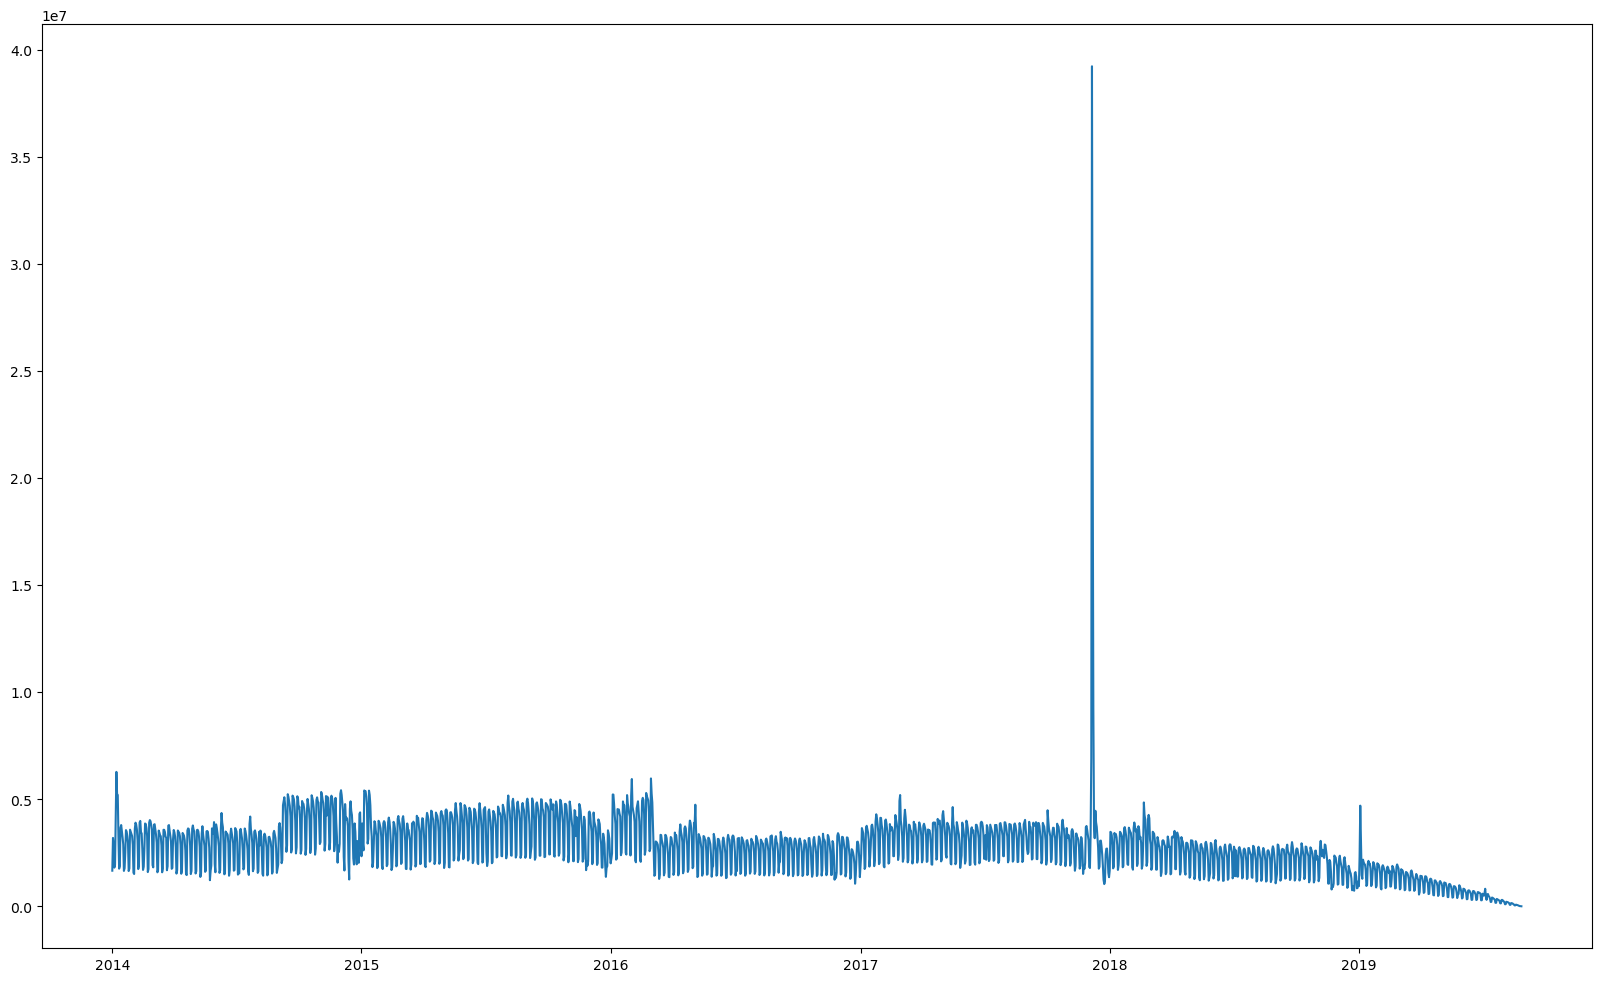

In [6]:
fig = plt.figure(figsize=(20,12))
plt.plot(df_total)
plt.show()

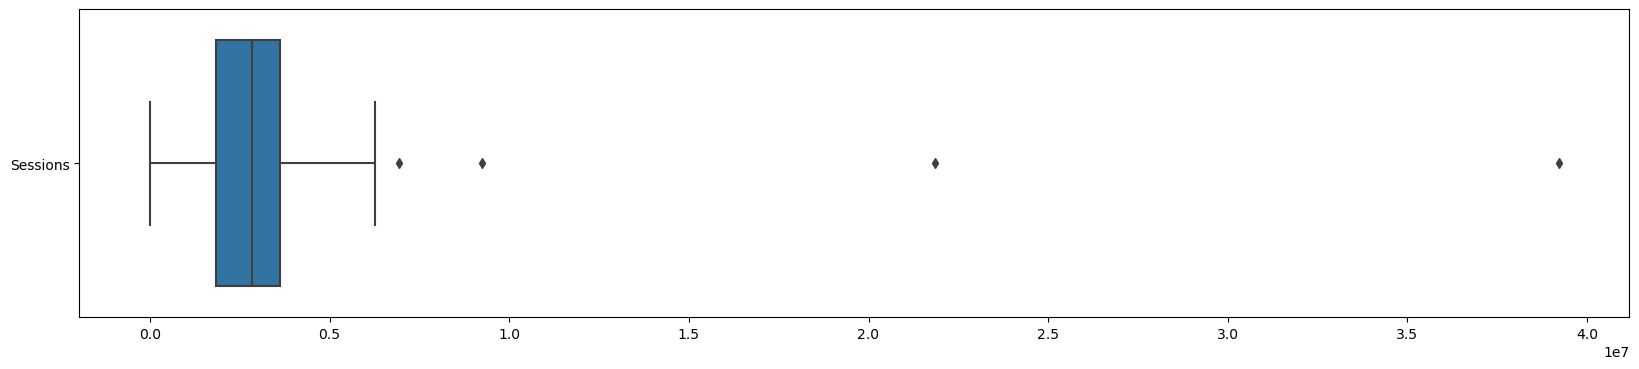

In [7]:
fig = plt.figure(figsize=(20,4))
sns.boxplot(df_total, orient='h')
plt.show()

---
## Handling Outliers 
### Removing the most extreme outliers and imputing them with mean value of the dataset
---

### Handling outliers for df_desktop

In [8]:
Q1 = np.percentile(df_total, 25)
Q3 = np.percentile(df_total, 75)
IQR = Q3 - Q1

L = Q1 - 1.5*IQR
U = Q3 + 1.5*IQR

df_total['Outlier'] = ((df_total['Sessions'] < L) | (df_total['Sessions'] > U))
df_total.loc[df_total['Outlier']==True]

,Sessions,Outlier
Date,,
2017-12-05,6934804,True
2017-12-06,39217826,True
2017-12-07,21842773,True
2017-12-08,9250668,True


In [9]:
#df_desktop.loc[df_desktop['Outlier'] == True].replace(df_desktop['Sessions'], df_desktop['Sessions'].mean())

mean_sessions = df_total.loc[df_total['Outlier'] == False, 'Sessions'].mean()
df_total.loc[df_total['Outlier'] == True, 'Sessions'] = mean_sessions

df_total = df_total.drop(columns=['Outlier'])

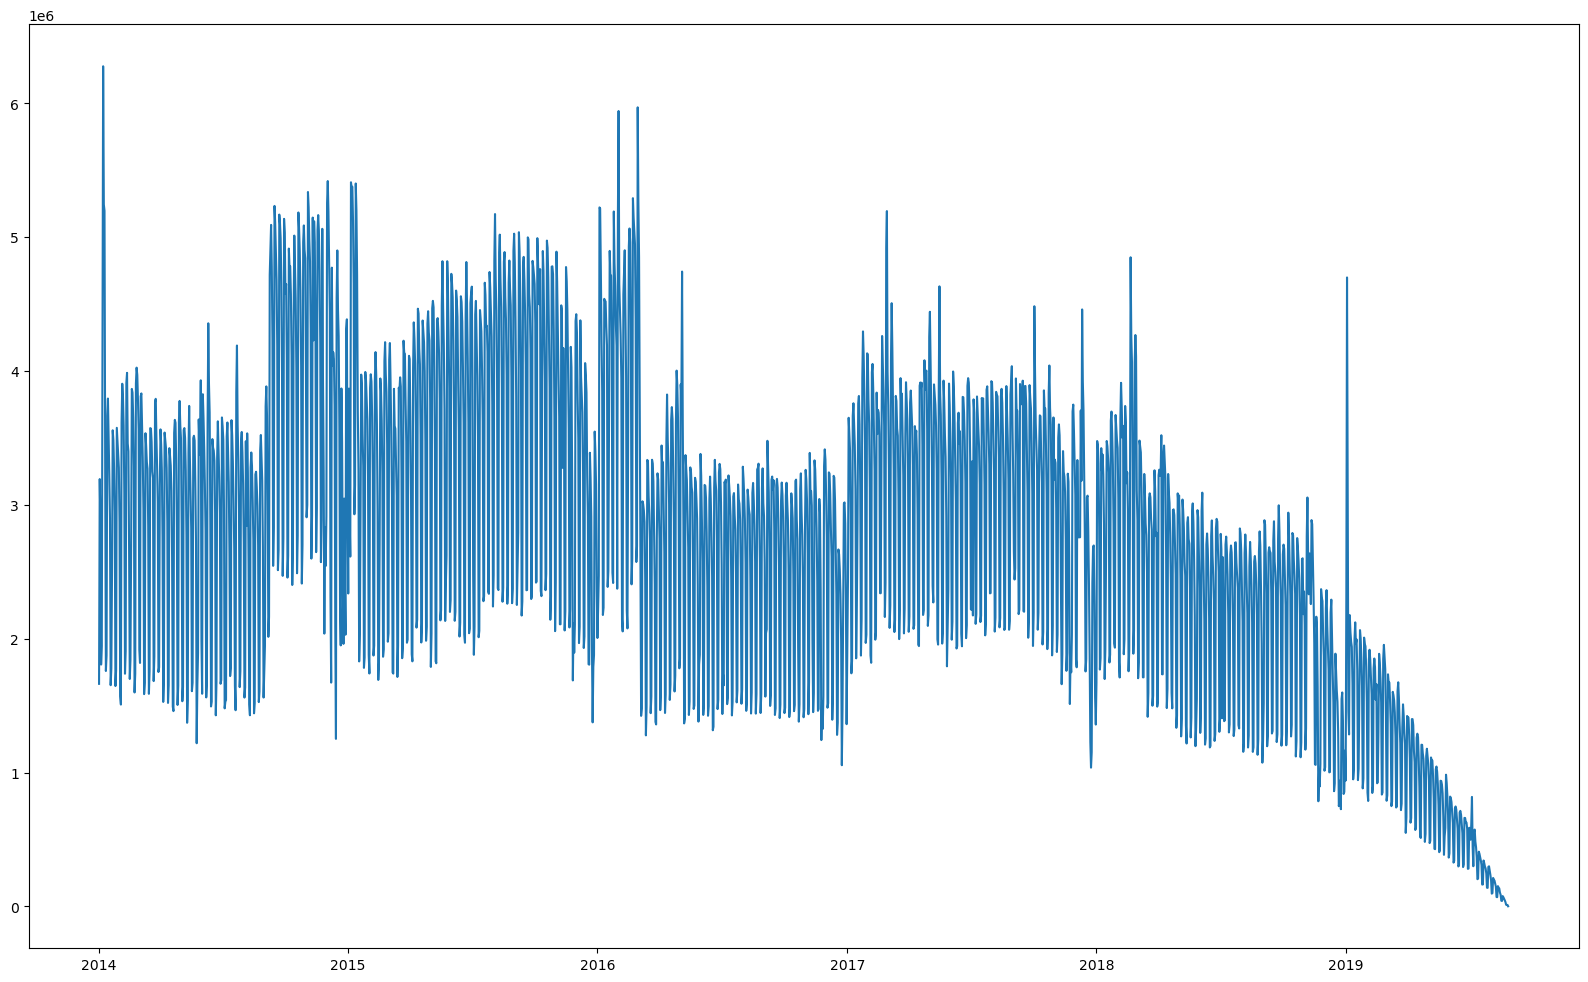

In [10]:
fig = plt.figure(figsize=(20,12))
plt.plot(df_total)
plt.show()

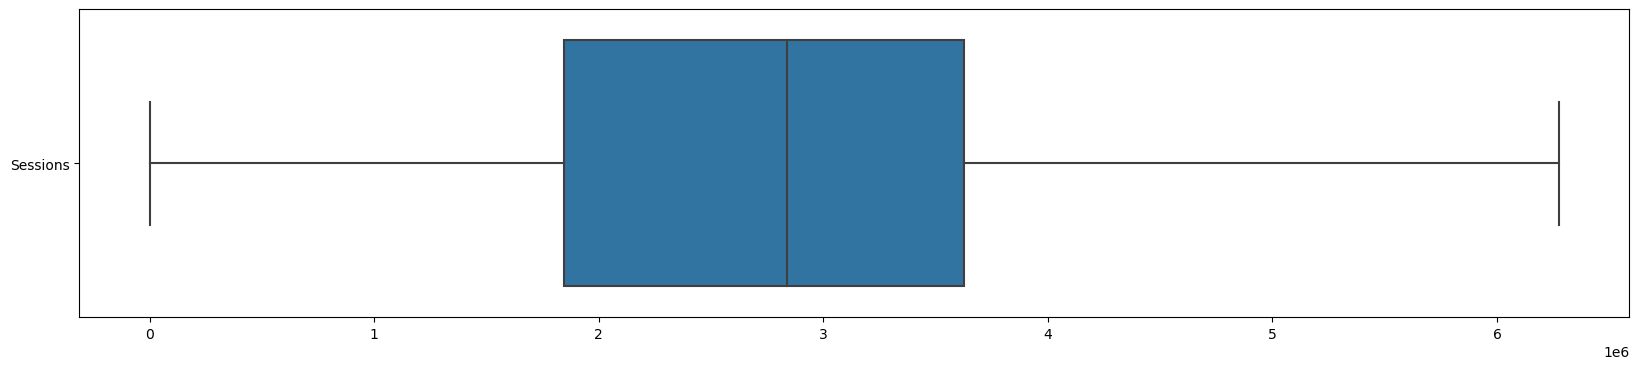

In [11]:
fig = plt.figure(figsize=(20,4))
sns.boxplot(df_total, orient='h')
plt.show()


---
# Stationarity tests

### Decomposition and Stationarity test for df_total

In [12]:
decomp = seasonal_decompose(df_total['Sessions'])
trend = decomp.trend
seasonal = decomp.seasonal
resid = decomp.resid


Decomposition of the endogenous variable


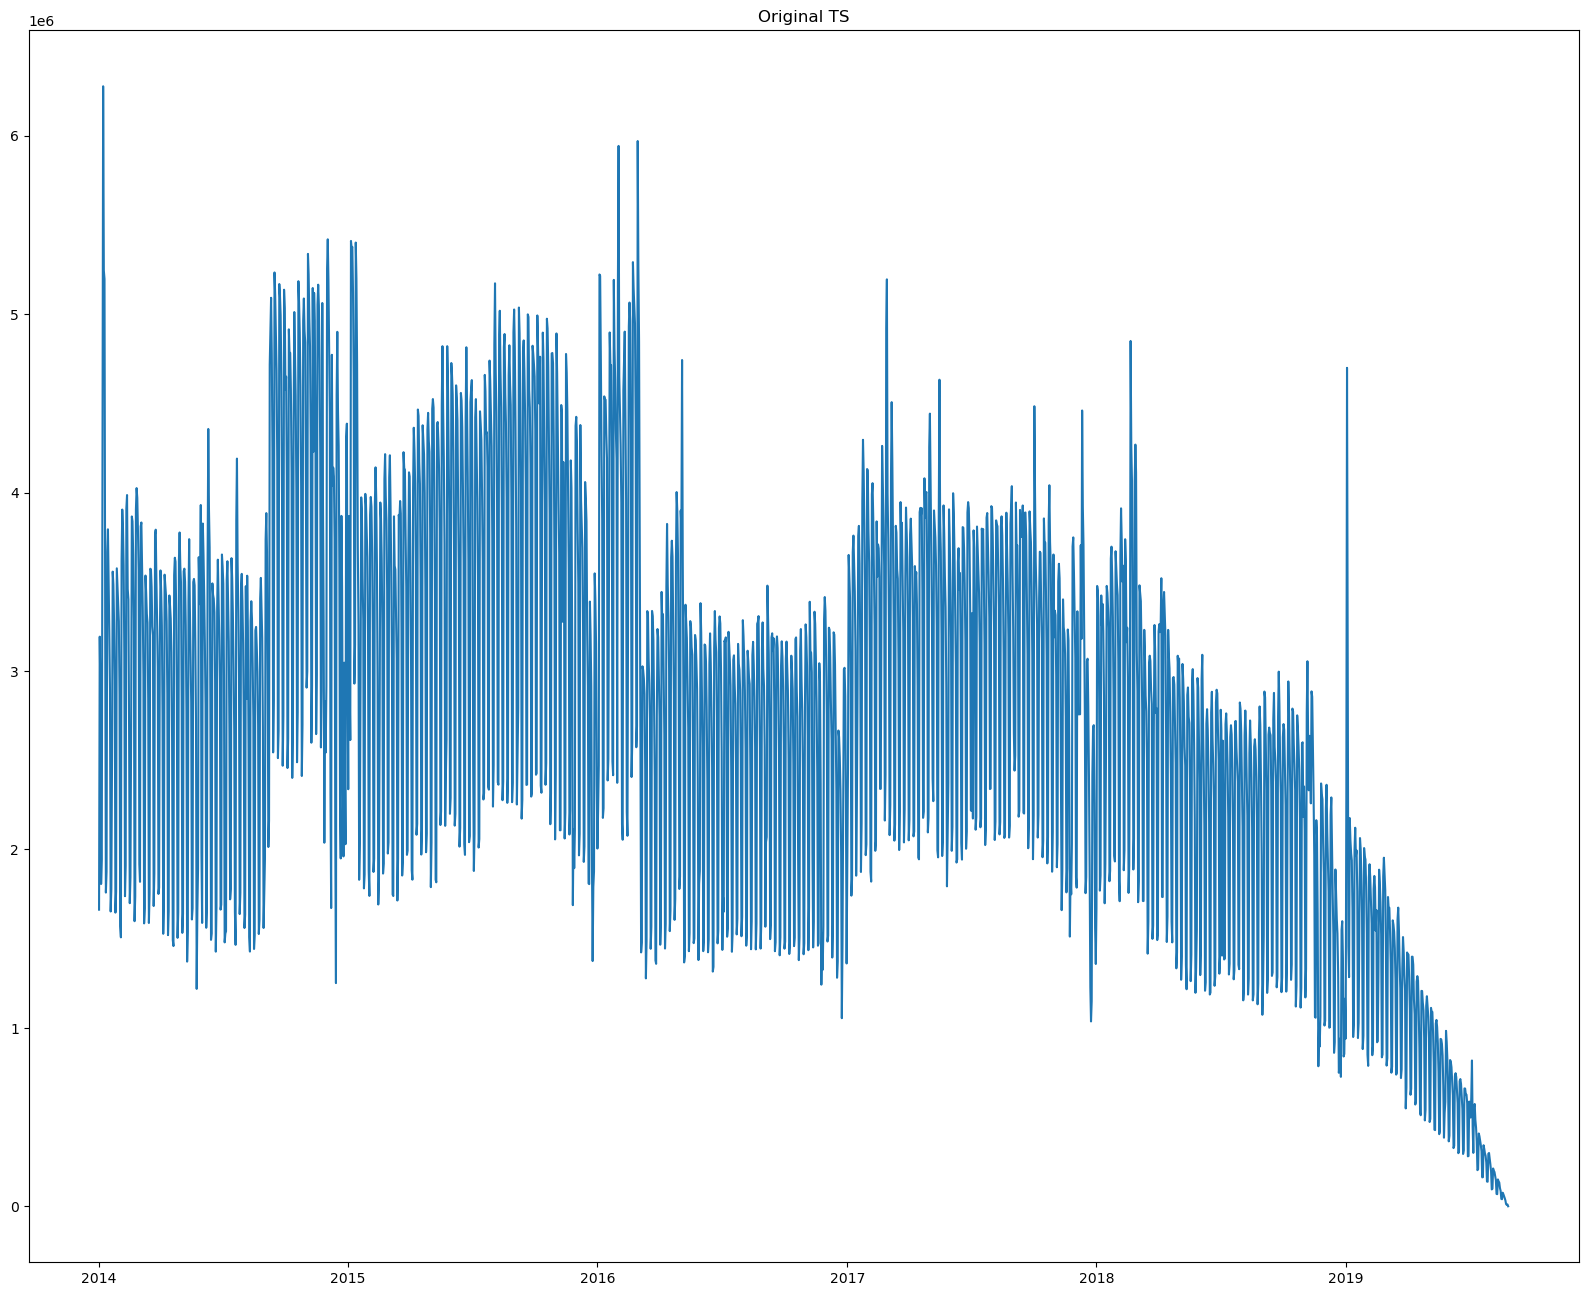

In [13]:
fig = plt.figure(figsize=(20,16))
plt.plot(df_total['Sessions'])
plt.title('Original TS')

print('\nDecomposition of the endogenous variable')

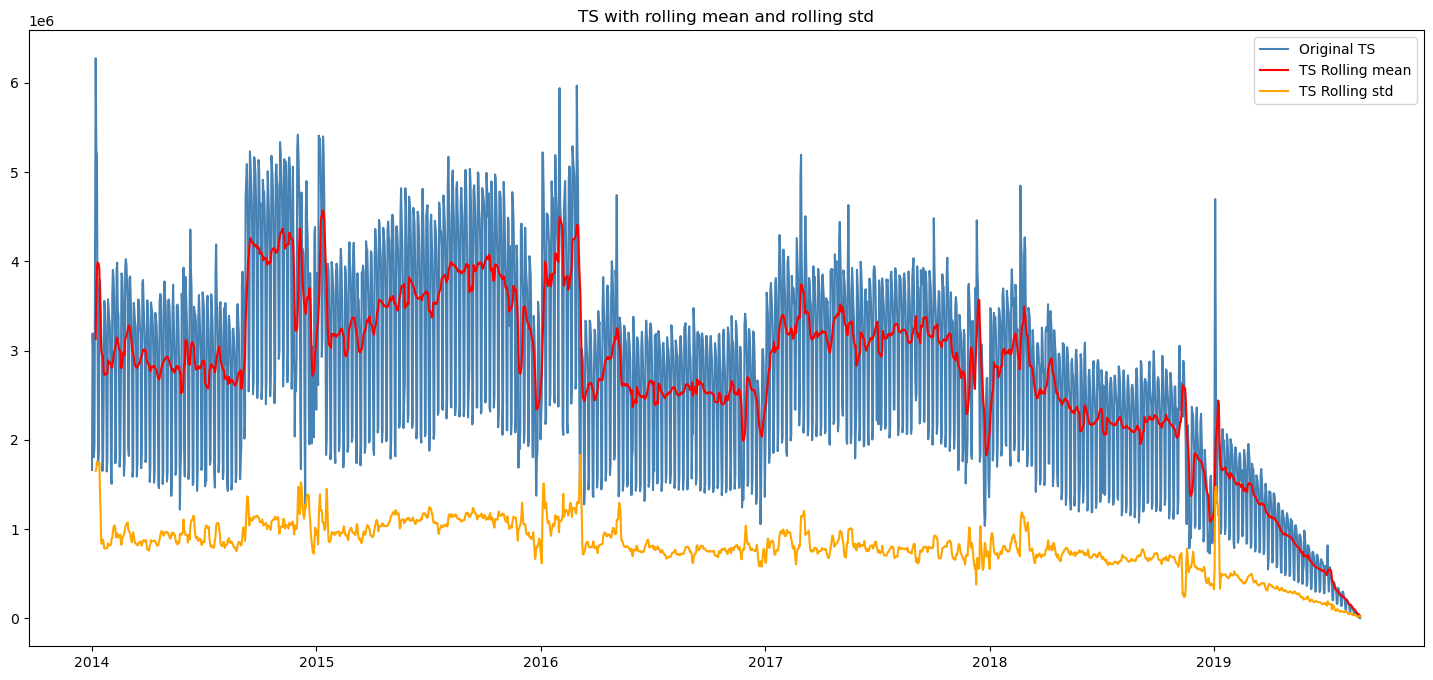

Results of the Augmented Dickey-Fuller test
Test stat.                -0.160682
p-value                    0.943049
#Lags chosen              26.000000
Total # observations    2038.000000
dtype: float64
Fail to reject Null-hypothesis (H0 accepted) -> Timeseries is NOT stationary.


In [14]:
def test_stationarity(timeseries, ssn_period: int, alpha: float = 0.05):
    # calculate rolling statistics
    rol_mean = timeseries.rolling(window=ssn_period).mean()
    rol_std = timeseries.rolling(window=ssn_period).std()
    
    # plot the ts and rolling metrics
    fig = plt.figure(figsize=(18,8))
    plt.plot(timeseries, color='steelblue', label='Original TS')
    plt.plot(rol_mean, color='red', label='TS Rolling mean')
    plt.plot(rol_std, color='orange', label='TS Rolling std')
    plt.legend(loc='best')
    plt.title("TS with rolling mean and rolling std")
    plt.show()

    print("Results of the Augmented Dickey-Fuller test")
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test stat.', 'p-value', '#Lags chosen', 'Total # observations'])
    print(dfoutput)
    if dfoutput['p-value'] > alpha:
        print("Fail to reject Null-hypothesis (H0 accepted) -> Timeseries is NOT stationary.")
    else:
        print("Rejection of Null-hypothesis (H0 rejected) -> Timeseries is stationary.")
    

test_stationarity(df_total['Sessions'], 7, 0.05)  

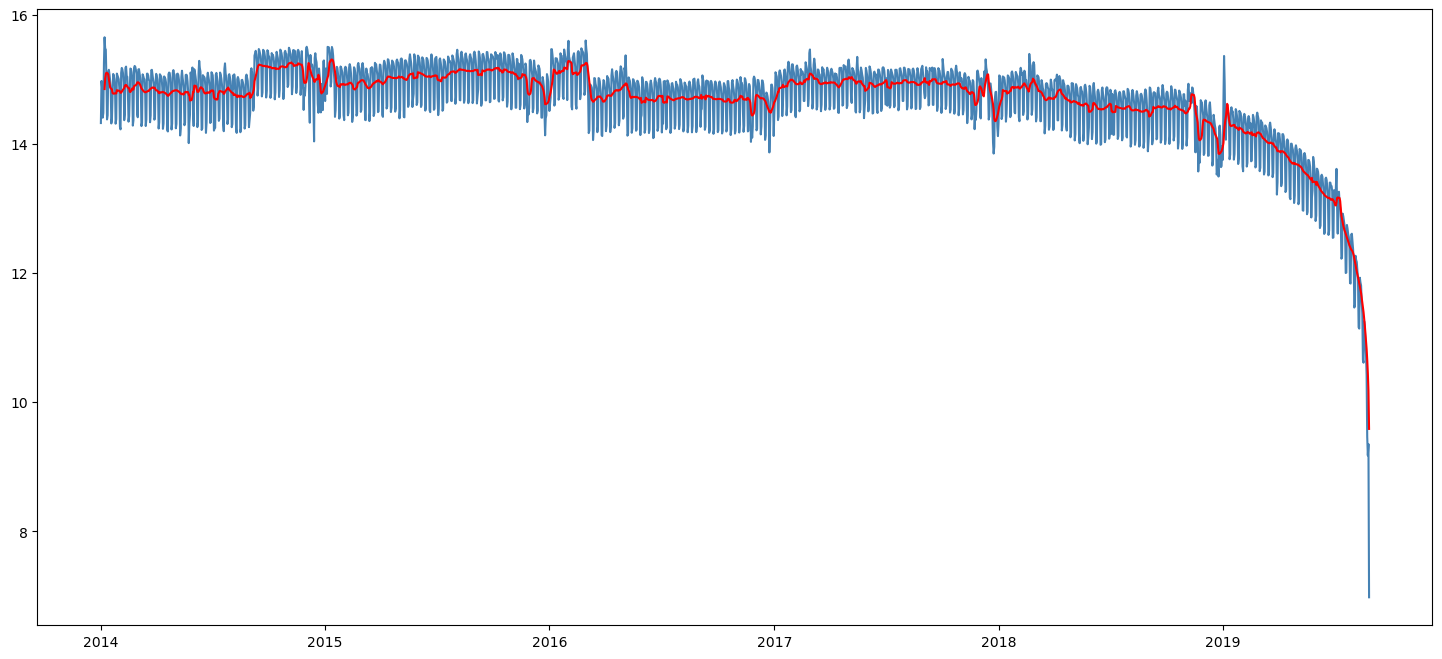

In [15]:
df_total_log = np.log(df_total)

moving_avg = df_total_log.rolling(window=7).mean()

fig = plt.figure(figsize=(18,8))
plt.plot(df_total_log, color='steelblue')
plt.plot(moving_avg, color='red')

In [16]:
# df_total_log.tail(50)

In [17]:
df_total_log = df_total_log[df_total_log.index <= '2018-10-01']

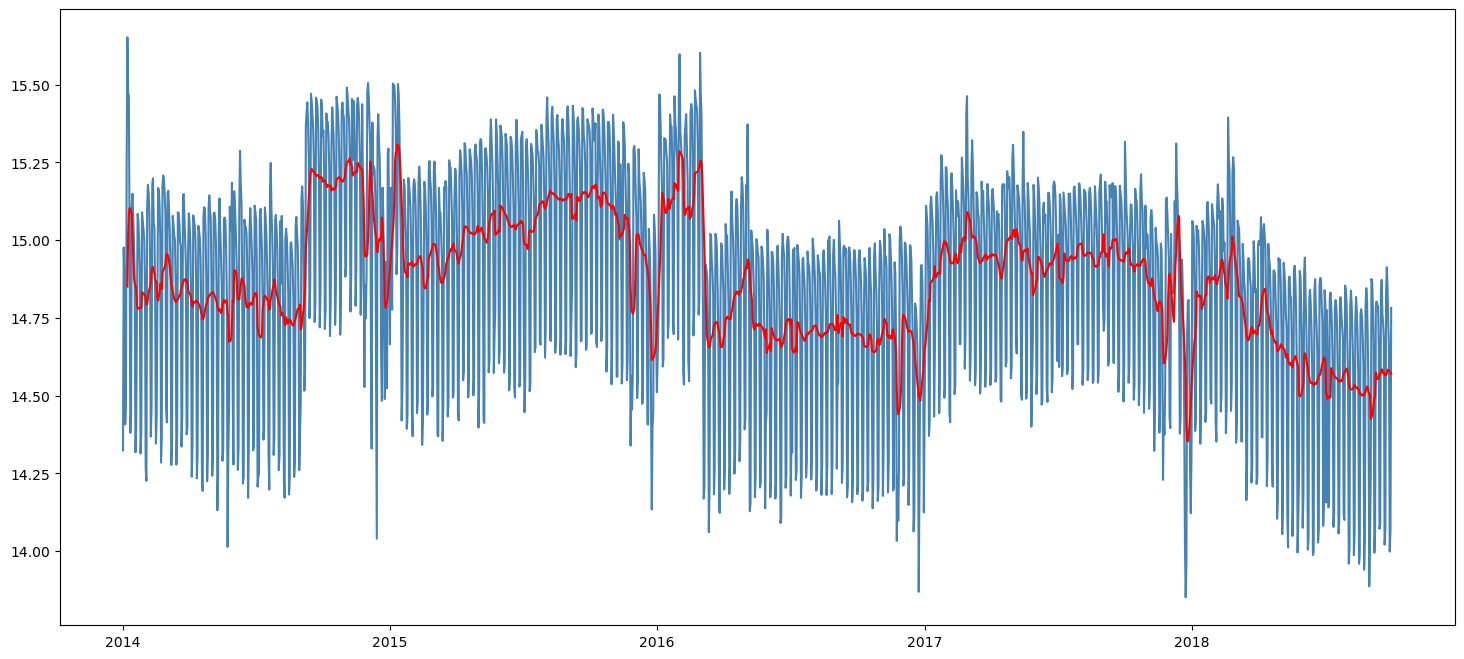

In [18]:
moving_avg = df_total_log.rolling(window=7).mean()

fig = plt.figure(figsize=(18,8))
plt.plot(df_total_log, color='steelblue')
plt.plot(moving_avg, color='red')

In [19]:
df_total_log_moving_mean_diff = df_total_log - moving_avg

df_total_log_moving_mean_diff.dropna(inplace=True)

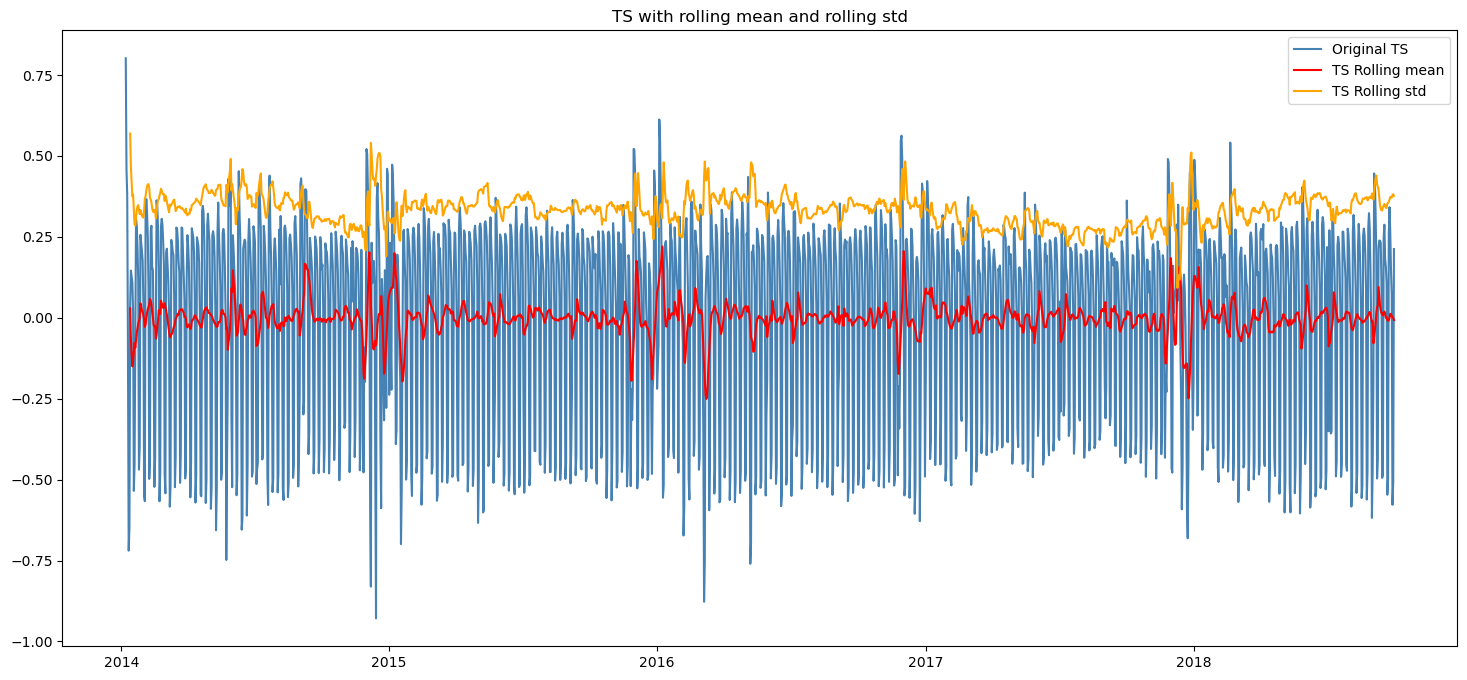

Results of the Augmented Dickey-Fuller test
Test stat.             -1.248396e+01
p-value                 3.047769e-23
#Lags chosen            2.300000e+01
Total # observations    1.705000e+03
dtype: float64
Rejection of Null-hypothesis (H0 rejected) -> Timeseries is stationary.


In [20]:
test_stationarity(df_total_log_moving_mean_diff, 7, 0.05)

In [21]:
# Saving the cleaned dataset for Time Series Forecasting

df_total_log.to_csv('df_total_final.csv')

---
# CONCLUSION from EDA, Data preprocessing and Data engineering:

---
## Handling outliers 
The most extreme 4 outliers shown as peak in the plot were deleted and then imputed with mean value of the dataset.    

## Decomposition of the endogenous variable

**Trend Component**: Does not show persistent increasing or decreasing direction in the data.

**Seasonal Component**: This component captures regular patterns that occur over a period of 7 days.

**Residual Component**: This component represents the remaining random fluctuations in the data after removing the trend and seasonal components. Nothing particular can be seen at this point.      

## Stationarity test: 
Stationary test faied, so I appled logarithm function and I did all the additional steps to make it stationary. 
    
Stationarity test after these transformations failed again. Here I assumed that the reason for this is the values in the last year - 2019, which are dropping sharply and they seemed as they were not real data. Since I have a large dataset, I decided to remove those values in order to obtain a better forecast. 

After this step the dataset passed the stationarity test and it is ready for Time Series Forecasting with ARIMA, SARIMA and PROPHET models.  

I'm saving the files in order to train the models on clean dataset in additional notebooks.
